In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
import os
# aggiungi la cartella Scripts al path di ricerca moduli
scripts_path = os.path.abspath(os.path.join('..', 'Scripts'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from funzioni import trimestri_stats, prezzo_trimestri_stats

In [3]:
# -------------------------------
# Lettura e preparazione dati
# -------------------------------
iphone15 = pd.read_csv("/Users/federicogamberini/VS Code/when-to-buy-iphone/Dataset/iPhone15.csv") 
iphone16 = pd.read_csv("/Users/federicogamberini/VS Code/when-to-buy-iphone/Dataset/iPhone16.csv")

combined = pd.concat([iphone15, iphone16], ignore_index=True)

stats_15 = trimestri_stats(iphone15, "iPhone15")
stats_16 = trimestri_stats(iphone16, "iPhone16")
df_statistiche = pd.concat([stats_15, stats_16], ignore_index=True)

# Ordine trimestri e aggiunta colonna Trimestre "Q..."
ordine_trimestri = ['T1', 'T2', 'T3', 'T4']
df_statistiche['Trimestre'] = pd.Categorical(df_statistiche['Trimestre'], categories=ordine_trimestri, ordered=True)
# Calcolo giorno medio per trimestre per plotting 
trimestre_to_giorni = {'T1': (0, 90),'T2': (91, 180),'T3': (181, 270),'T4': (271, 365)}
df_statistiche['Giorni_dal_lancio'] = df_statistiche['Trimestre'].map(
    lambda q: sum(trimestre_to_giorni[q]) // 2 if pd.notna(q) else None)
# Colori
palette = {'iPhone15': 'red','iPhone16': 'blue'}
trimestre_color = {
    'T1': '#D1E8FF',
    'T2': '#DFFFD1',
    'T3': '#FFEAD1',
    'T4': '#F3D1FF'
}

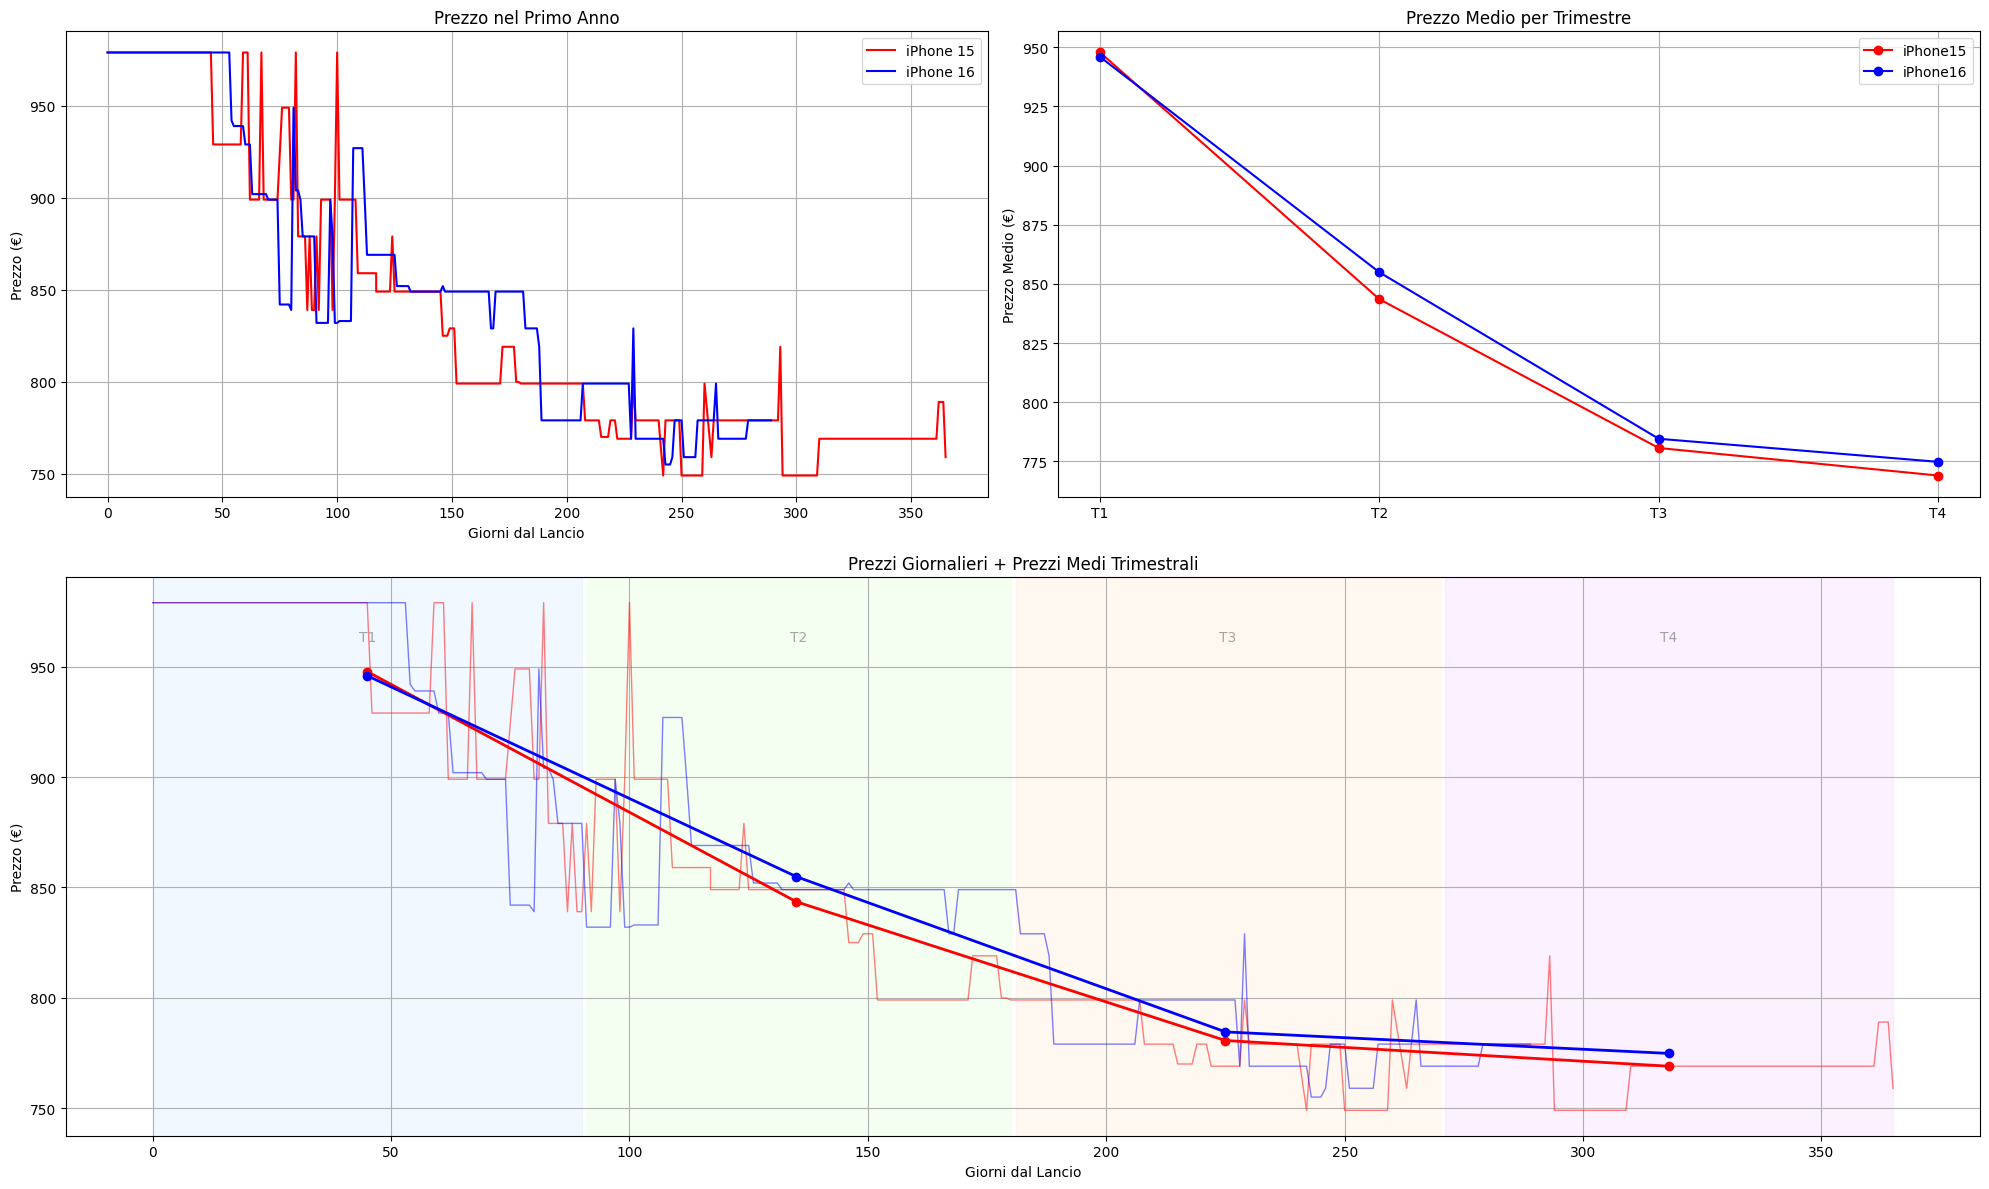

In [4]:
# -------------------------------
# Plotting con GridSpec
# -------------------------------

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])

# --- Plot 1: Prezzo nel primo anno ---
ax1 = fig.add_subplot(gs[0, 0])
iphone15_anno1 = iphone15[iphone15['Giorni_dal_lancio'] <= 365]
ax1.plot(iphone15_anno1['Giorni_dal_lancio'], iphone15_anno1['Prezzo'], label='iPhone 15', color='red')
ax1.plot(iphone16['Giorni_dal_lancio'], iphone16['Prezzo'], label='iPhone 16', color='blue')
ax1.set_title('Prezzo nel Primo Anno')
ax1.set_xlabel('Giorni dal Lancio')
ax1.set_ylabel('Prezzo (€)')
ax1.grid(True)
ax1.legend()

# --- Plot 2: Prezzo medio per trimestre ---
ax2 = fig.add_subplot(gs[0, 1])
trimestri_validi = ['T1', 'T2', 'T3', 'T4']
for modello in df_statistiche['Modello'].unique(): # Ciclo su tutti i modelli unici, quindi 2
    df_mod = df_statistiche[(df_statistiche['Modello'] == modello) & (df_statistiche['Trimestre'].isin(trimestri_validi))] #df filtrato con solo i trimestri validi 
    ax2.plot(df_mod['Trimestre'], df_mod['mean'], marker='o', label=modello, color=palette[modello])
ax2.set_title('Prezzo Medio per Trimestre')
ax2.set_ylabel('Prezzo Medio (€)')
ax2.grid(True)
ax2.legend()

# --- Plot 3: Prezzi giornalieri + medi con aree Q ---
ax3 = fig.add_subplot(gs[1, :])
# Aree colorate per i trimestri (Q1–Q4)
for trimestre, (start, end) in trimestre_to_giorni.items(): #Cicla sul dizionario trimestre_to_giorni
    ax3.axvspan(start, end, color=trimestre_color[trimestre], alpha=0.3) #axvspan crea un’area verticale
    ax3.text((start + end) / 2, df_statistiche['mean'].max() * 1.02, trimestre,
             ha='center', va='top', fontsize=10, color='gray', alpha=0.7)
# Prezzi giornalieri
for modello in combined['Modello'].unique(): 
    df_comb = combined[(combined['Modello'] == modello) & (combined['Giorni_dal_lancio'] <= 365)]
    ax3.plot(df_comb['Giorni_dal_lancio'], df_comb['Prezzo'], alpha=0.5,
             label=f'{modello} giornaliero', color=palette[modello], linewidth=1)
# Prezzi medi trimestrali
for modello in df_statistiche['Modello'].unique():
    df_mod = df_statistiche[
        (df_statistiche['Modello'] == modello) &
        (df_statistiche['Trimestre'].isin(trimestri_validi)) &
        (df_statistiche['Giorni_dal_lancio'] <= 365)]
    ax3.plot(df_mod['Giorni_dal_lancio'], df_mod['mean'], marker='o',label=f'{modello} medio', color=palette[modello], linewidth=2)
ax3.set_title('Prezzi Giornalieri + Prezzi Medi Trimestrali')
ax3.set_xlabel('Giorni dal Lancio')
ax3.set_ylabel('Prezzo (€)')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# -------------------------------
# Statistiche Riassuntive
# -------------------------------
resoconto_15 = iphone15.groupby(['Trimestre'], observed=True).apply(prezzo_trimestri_stats, include_groups=False).reset_index()
resoconto_16 = iphone16.groupby(['Trimestre'], observed=True).apply(prezzo_trimestri_stats, include_groups=False).reset_index()

In [6]:
print(f"iPhone 15 - Resoconto Prezzi per Trimestre:")
resoconto_15

iPhone 15 - Resoconto Prezzi per Trimestre:


,Trimestre,Prezzo Iniziale,Prezzo Finale,Prezzo Medio Trimestre,Variazione Totale (€),Variazione Totale (%),Oscillazione Massima (€),Volatilità (std dev)
0,T1,979.0,839.0,947.78,-140.0,-14.30,140.00,40.608511
1,T2,879.0,799.0,843.50,-80.0,-9.10,180.00,36.163236
2,T3,799.0,779.0,780.64,-20.0,-2.50,50.00,16.290895
3,T4,779.0,759.0,769.00,-20.0,-2.57,70.00,11.485421
4,T5,759.0,699.0,735.05,-60.0,-7.91,107.01,29.535575
5,T6,699.0,699.0,729.96,0.0,0.00,50.00,15.457845
6,T7,699.0,669.0,691.73,-30.0,-4.29,84.00,22.566655
7,T8,669.0,659.0,664.88,-10.0,-1.49,40.00,10.036697


In [ ]:
print(f"iPhone 16 - Resoconto Prezzi per Trimestre:")
resoconto_16

iPhone 16 - Resoconto Prezzi per Trimestre:


,Trimestre,Prezzo Iniziale,Prezzo Finale,Prezzo Medio Trimestre,Variazione Totale (€),Variazione Totale (%),Oscillazione Massima (€),Volatilità (std dev)
0,T1,979.00,879.0,945.91,-100.00,-10.21,140.00,45.062622
1,T2,831.99,849.0,854.87,17.01,2.04,97.99,22.011522
2,T3,849.00,769.0,784.53,-80.00,-9.42,94.00,20.243573
3,T4,769.00,779.0,773.67,10.00,1.30,10.00,5.163978
